<a href="https://colab.research.google.com/github/dkioroglou/programmers_salaries_2023/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/dkioroglou/programmers_salaries_2023/main/data/salaries_2023.csv")

In [ ]:
df = df[[
      '[Fixed] Ποιος είναι ο ΕΤΗΣΙΟΣ ΚΑΘΑΡΟΣ μισθός σου σε €;',
      'Με ποιες γλώσσες προγραμματισμού δουλεύεις επαγγελματικά αυτή την περίοδο;',
      'Πόσα χρόνια δουλεύεις επαγγελματικά ως προγραμματιστής;',
      'Φύλλο;',
      '[GROUP] Σε ποια πόλη δουλεύεις, Greece ή Abroad',
      'Τι μέγεθος είναι η εταιρεία που δουλεύεις;'
      ]]

df.columns = [
      'salary',
      'languages',
      'experience',
      'gender',
      'jobLocation',
      'companySize'
      ]

# Missing values distribution

In [ ]:
df.isna().sum()

salary         0
languages      0
experience     0
gender         2
jobLocation    0
companySize    0
dtype: int64

In [ ]:
df['gender'].value_counts()

Άντρας               949
Γυναίκα               53
Προτιμώ να μην πω      1
Nuclear Sub            1
Name: gender, dtype: int64

In [ ]:
mask = df.isna()['gender']
df[mask]

,salary,languages,experience,gender,jobLocation,companySize
64,19600.0,"JavaScript, Ruby",7,NaN,Ελλάδα,201 - 500
541,10100.0,"Java, JavaScript",1,NaN,Ελλάδα,101 - 200


In [ ]:
# Remove entries with missing or unspecified gender
df =  df.drop([64, 541, 68, 167])

# Distribution of salaries

In [ ]:
df['salary'].describe()

count      1002.000000
mean      24117.334262
std       16305.507428
min          15.008000
25%       14820.000000
50%       20155.000000
75%       27595.000000
max      180000.000000
Name: salary, dtype: float64

<Axes: xlabel='salary', ylabel='Count'>

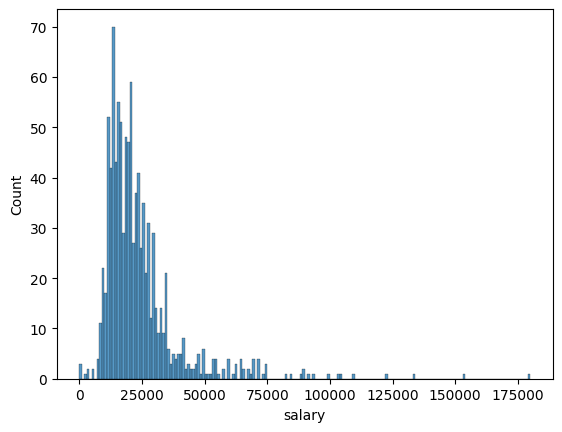

In [ ]:
sns.histplot(df['salary'], binwidth=1000)

In [ ]:
# Remove outliers
# Select data with salaries between the 10th and 90th percentiles of salaries
perc10th =  df['salary'].quantile(0.1)
perc90th = df['salary'].quantile(0.9)
df = df.query('salary >= @perc10th & salary <= @perc90th')

<Axes: xlabel='salary', ylabel='Count'>

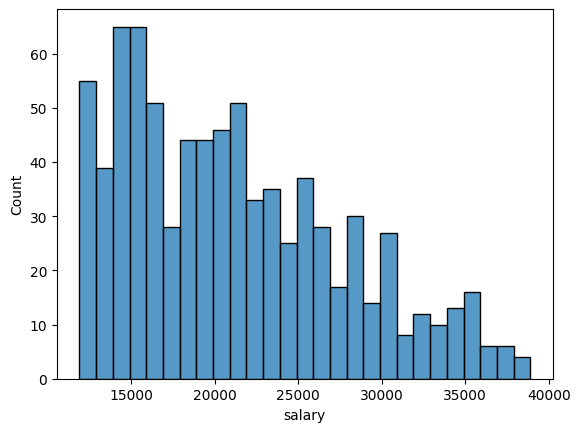

In [ ]:
sns.histplot(df['salary'], binwidth=1000)

In [ ]:
df.shape

(809, 6)

# Gender distribution after filtering

In [ ]:
df['gender'].value_counts()

Άντρας     768
Γυναίκα     41
Name: gender, dtype: int64

## Feature engineering and recoding

In [ ]:
df['languagesNumber'] = df['languages'].map(lambda x: len(x.split(",")) if ',' in x else 1)

In [ ]:
df['companySize'].value_counts()

501+         256
11 - 50      179
201 - 500    106
51 - 100      94
101 - 200     92
1 - 10        82
Name: companySize, dtype: int64

In [ ]:
df['companySizeBinned'] = df['companySize'].map({
                                                '1 - 10':'small',
                                                '11 - 50': 'small',
                                                '51 - 100': 'small',
                                                '101 - 200': 'medium',
                                                '201 - 500': 'medium',
                                                '501+': 'large'
                                                })

In [ ]:
df['companySizeBinned'].value_counts()

small     355
large     256
medium    198
Name: companySizeBinned, dtype: int64

In [ ]:
df['companySizeBinnedRecoded'] = df['companySizeBinned'].map({"small":1, "medium":2, "large": 3})

In [ ]:
df['genderRecoded'] = df['gender'].map({"Άντρας":1, "Γυναίκα":0})

In [ ]:
df['jobLocationRecoded'] = df['jobLocation'].map({"Ελλάδα":1, "Εξωτερικό":0})

# Ordinary Least Square regression

In [ ]:
df.columns

Index(['salary', 'languages', 'experience', 'gender', 'jobLocation',
       'companySize', 'languagesNumber', 'companySizeBinned',
       'companySizeBinnedRecoded', 'genderRecoded', 'jobLocationRecoded'],
      dtype='object')

In [ ]:
X = df[['genderRecoded', 'experience', 'languagesNumber', 'companySizeBinnedRecoded', 'jobLocationRecoded']]
X.insert(0, 'intercept', 1)
y = df['salary']

In [ ]:
model = sm.OLS(y, X).fit()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     76.04
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           2.85e-65
Time:                        13:25:05   Log-Likelihood:                -8095.5
No. Observations:                 809   AIC:                         1.620e+04
Df Residuals:                     803   BIC:                         1.623e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                 2.264e+04   1245.599     18.176      0.000    2.02e+04    2.51e+04
genderRecoded              712.8264    865.005      0.824      0.410    -985.112    2410.764
experience                 717.7014     45.529     15.764      0.000     628.332     807.070
languagesNumber            -73.7877    223.683     -0.330      0.742    -512.860     365.285
companySizeBinnedRecoded  1037.6986    220.377      4.709      0.000     605.115    1470.282
jobLocationRecoded       -7683.0672    713.801    -10.764      0.000   -9084.204   -6281.931
==============================================================================
Omnibus:                       25.372   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.106
Skew:                          -0.020   Prob(JB):                     8.88e-14
Kurtosis:                       4.335   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

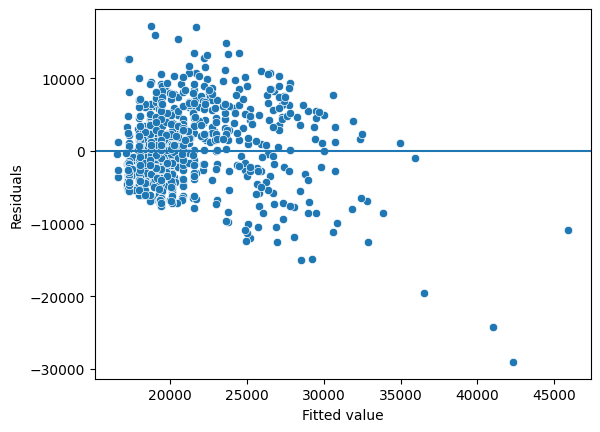

In [ ]:
# Plot residuals
sns.scatterplot(
    x=model.get_prediction().summary_frame()['mean'],
    y=model.resid
    )
plt.axhline(y=0)
plt.xlabel("Fitted value")
plt.ylabel("Residuals")
plt.show()

In [ ]:
model.params

intercept                   22640.493550
genderRecoded                 712.826352
experience                    717.701417
languagesNumber               -73.787692
companySizeBinnedRecoded     1037.698576
jobLocationRecoded          -7683.067187
dtype: float64

In [ ]:
22640 - 7683

14957